Thanks to https://www.kaggle.com/cdeotte/data-without-drift.

Thanks to https://www.kaggle.com/ragnar123/clean-kalman #Clean data with kelman Filter


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
B_NUM = 10
B_SIZE = 500000

In [3]:
!pip install catboost

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# imports
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
import lightgbm as lgb
from scipy import fftpack
import librosa
from catboost import CatBoostRegressor


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


./drive/My Drive/Colab Notebooks/liverpool-ion-switching/a-signal-processing-approach-low-pass-filtering.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/3-simple-ideas-lb-0-938.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/use_sound_feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/simple_Boosting.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/wavenet-with-1-more-feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/on-markov-chains-and-the-competition-data.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/single-model-lgbm-kalman-filter.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/shifted-rfc-pipeline.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/ion-weighted-voting-ensemble.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/music_feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/lgbm-with-shifted-rfc-proba-and-cbr.ipynb

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [6]:
kal_data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean_kalman_batch7_gause_rem_50hz.csv')
data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean.csv')



# data = data[B_SIZE:2*B_SIZE]
# data.reset_index(inplace=True)
# data.drop('index', axis=1, inplace=True)
data

,time,signal,open_channels
0,0.0001,-2.760000,0
1,0.0002,-2.855700,0
2,0.0003,-2.407400,0
3,0.0004,-3.140400,0
4,0.0005,-3.152500,0
...,...,...,...
4999995,499.9996,2.932577,7
4999996,499.9997,2.711208,7
4999997,499.9998,4.529640,8
4999998,499.9999,5.652972,9


**Feature Engineering**: Thanks to  https://www.kaggle.com/martxelo/fe-and-simple-mlp 

In [0]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [0]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [0]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [0]:
def calc_roll_stats(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        r = s.rolling(window=w, min_periods=1, center=True)
        roll_stats['roll_mean_' + str(w)] = r.mean()
        roll_stats['roll_std_' + str(w)] = r.std()
        roll_stats['roll_min_' + str(w)] = r.min()
        roll_stats['roll_max_' + str(w)] = r.max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_median_' + str(w)] = r.median()
        # roll_stats['roll_skew_' + str(w)] = r.skew()
        # roll_stats['roll_q10_' + str(w)] = r.quantile(0.10)
        # roll_stats['roll_q25_' + str(w)] = r.quantile(0.25)
        # roll_stats['roll_q50_' + str(w)] = r.quantile(0.50)
        # roll_stats['roll_q75_' + str(w)] = r.quantile(0.75)
        # roll_stats['roll_q90_' + str(w)] = r.quantile(0.90)
        # roll_stats['roll_agg_sum' + str(w)] = r.aggregate(np.sum)
        # roll_stats['roll_agg_mean' + str(w)] = r.aggregate(np.mean)
        # roll_stats['roll_agg_std' + str(w)] = r.aggregate(np.std)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [0]:
def calc_ewm(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        e = s.ewm(span=w, min_periods=1)
        ewm['ewm_mean_' + str(w)] = e.mean()
        ewm['ewm_std_' + str(w)] = e.std()

        # ewm['ewm_agg_mean' + str(w)] = e.aggregate(np.mean)
        # ewm['ewm_agg_std' + str(w)] = e.aggregate(np.std)
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [0]:
# get lead and lags features
def lag_with_pct_change(s, windows):
    shift = pd.DataFrame()
    for window in windows:    
        shift['signal_shift_pos_' + str(window)] = s.shift(window).fillna(0)
        shift['signal_shift_neg_' + str(window)] = s.shift(-1 * window).fillna(0)
    return shift

In [0]:
# get lead and lags features
def two_sig(s):
    two = pd.DataFrame()
    two['two_sig'] = s.values ** 2 

    return two

In [0]:
def calc_mfcc(s, signal_size, windows=[128, 256, 512, 1024]):

  mfcc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    mfcc_ = librosa.feature.mfcc(y=s.values, n_mfcc=12, sr=96000, hop_length=window, n_fft=window, n_mels=int(window/16))
    mfcc_lists = []
    for i in range(len(mfcc_[0])):
      mfcc_list = [mfcc_[0][i]] * window
      mfcc_lists.extend(mfcc_list)
    mfcc['signal_mfcc_' + str(window)] = mfcc_lists[:signal_size]
  # print(len(mfcc))

  return mfcc

In [0]:
def spectral_centroid(s, windows=[100, 500, 1000]):

  sc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    sc_ = librosa.feature.spectral_centroid(y=s.values, sr=96000, hop_length=window, n_fft=window)
    sc_lists = []
    for i in range(len(sc_[0])):
      sc_list = [sc_[0][i]] * window
      sc_lists.extend(sc_list)
    sc['signal_sc' + str(window)] = sc_lists[:500000]
  # print(len(mfcc))

  return sc

In [0]:
def calc_roll_off(s, windows=[100, 500, 1000]):

  sc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    sc_ = librosa.feature.spectral_rolloff(y=s.values, sr=96000, hop_length=window, n_fft=window)
    sc_lists = []
    for i in range(len(sc_[0])):
      sc_list = [sc_[0][i]] * window
      sc_lists.extend(sc_list)
    sc['signal_sc' + str(window)] = sc_lists[:500000]
  # print(len(mfcc))

  return sc

In [0]:
def calc_zerocross(s, windows=[500]):

  zc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    zc_ = librosa.feature.zero_crossing_rate(y=s.values, frame_length=window, hop_length=window)
    zc_lists = []
    for i in range(len(zc_[0])):
      zc_list = [zc_[0][i]] * window
      zc_lists.extend(zc_list)
    zc['signal_zc_' + str(window)] = zc_lists[:500000]

  # print(len(zc_[0]))

  return zc

In [0]:
def add_group(me, i, signal_size=500000):
  if(me == 'train'):
    df_group = pd.DataFrame()
    num = [0, 0, 1, 2, 3, 4, 1, 2, 4, 3]
    lst = [num[i]] * signal_size
    df_group['group'] = lst
    # df = pd.concat([df, df_group], axis=1)

  else:
    df_group = pd.DataFrame()
    num = [0, 2, 3, 0, 1, 4, 3, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
    lst = [num[i]] * signal_size
    df_group['group'] = lst

  return df_group


In [0]:
def add_features(s, me, i, signal_size):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    shift = lag_with_pct_change(s, [1, 2, 3, 4])
    mfcc = calc_mfcc(s, signal_size)
    two = two_sig(s)
    # zc = calc_zerocross(s)
    # sc = spectral_centroid(s)
    # ro = calc_roll_off(s)
    # gr = add_group('train', i)
    # agg = calc_agg(s)
    # fft_ = calc_fft(s)
    # print('ewm = ', len(fft_))
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)
    # return pd.concat([s, low_pass, roll_stats, two], axis=1)


def divide_and_add_features(s, me, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0

    # s = remove_batch7_spike(s)
    plt.plot(s)
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig, me, i, signal_size)
        ls.append(sig_featured)
        # break
    
    return pd.concat(ls, axis=0)

def remove_batch7_spike(df):
    b_size = 500000
    
    # df['signal_aranged'] = df['signal'].values
    
    data_7 = df[7*b_size:8*b_size]
    
    batch7_outlier_idx = data_7.query('signal >= 2.2 or signal <= -3.7').index

    # print(df['signal_aranged'][batch7_outlier_idx[0]])
    # batch7_outlier_idx_ = pd.Int64Index(range(batch7_outlier_idx[0], batch7_outlier_idx[-1] + 1))
    df['signal'][batch7_outlier_idx] = 1
    
    return df

100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Mem. usage decreased from 3585.82 Mb to 925.06 Mb (74.2% reduction)


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_min_10,roll_max_10,roll_range_10,roll_median_10,roll_mean_50,roll_std_50,roll_min_50,roll_max_50,roll_range_50,roll_median_50,roll_mean_100,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,ewm_mean_5,ewm_std_5,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000
0,-0.182007,-0.005802,0.017029,-0.018829,0.001498,-0.182007,-0.184570,-0.182007,-0.184692,-0.182007,-0.184326,-0.182007,-0.183594,-0.182007,-0.182861,-0.182007,-0.182251,-0.182007,-0.182129,-0.182007,-0.182007,-0.182007,-0.182007,-0.182007,-0.182007,0.000000,0.002531,-0.000000,0.002569,0.000000,0.002085,0.000000,0.001256,0.000000,0.000497,0.000000,0.000088,0.000000,-0.000009,0.000000,...,-0.207642,-0.159546,0.048004,-0.187866,-0.186035,0.015511,-0.210571,-0.153442,0.057220,-0.183105,-0.186279,0.016357,-0.211548,-0.135620,0.075928,-0.186523,-0.181152,0.015854,-0.220703,-0.135620,0.085083,-0.181274,-0.180542,0.015869,-0.225342,-0.13562,0.089661,-0.180542,-0.182007,0.000000,-0.182007,0.000000,-0.182007,0.000000,-0.182007,0.000000,-0.182007,0.000000,-0.182007,0.000000
1,-0.187866,0.011230,-0.001789,-0.017319,0.013031,-0.182129,-0.184570,-0.182129,-0.184692,-0.182251,-0.184326,-0.182373,-0.183716,-0.182495,-0.183105,-0.182739,-0.182739,-0.183105,-0.182617,-0.183472,-0.182129,-0.184082,-0.180908,-0.184937,-0.179321,-0.005714,-0.003284,-0.005657,-0.003214,-0.005573,-0.003645,-0.005436,-0.004391,-0.005226,-0.004997,-0.004917,-0.005238,-0.004467,-0.005508,-0.003841,...,-0.207642,-0.159546,0.048004,-0.184937,-0.186401,0.015282,-0.210571,-0.153442,0.057220,-0.185425,-0.186401,0.016205,-0.211548,-0.135620,0.075928,-0.187866,-0.181152,0.015823,-0.220703,-0.135620,0.085083,-0.181274,-0.180542,0.015854,-0.225342,-0.13562,0.089661,-0.180542,-0.185547,0.004105,-0.185181,0.004105,-0.185059,0.004105,-0.184937,0.004105,-0.184937,0.004105,-0.184937,0.004105
2,-0.159546,-0.009384,-0.017609,0.007244,0.017929,-0.181885,-0.184570,-0.181763,-0.184692,-0.181641,-0.184448,-0.181396,-0.183838,-0.181030,-0.183472,-0.180542,-0.183350,-0.179688,-0.183716,-0.178467,-0.183716,-0.176636,-0.182373,-0.173706,-0.178345,0.022293,0.024979,0.022186,0.025085,0.022018,0.024734,0.021729,0.024109,0.021271,0.023743,0.020538,0.023956,0.019348,0.024246,0.017471,...,-0.207642,-0.159546,0.048004,-0.182007,-0.186523,0.015007,-0.210571,-0.153442,0.057220,-0.187866,-0.186768,0.016357,-0.211548,-0.135620,0.075928,-0.188232,-0.181030,0.015854,-0.220703,-0.135620,0.085083,-0.181274,-0.180542,0.015854,-0.225342,-0.13562,0.089661,-0.180542,-0.173218,0.016510,-0.174927,0.015747,-0.176147,0.015099,-0.176392,0.015015,-0.176514,0.014946,-0.176514,0.014938
3,-0.206665,-0.024002,0.012703,0.018539,-0.008575,-0.181885,-0.184570,-0.181885,-0.184692,-0.181763,-0.184570,-0.181641,-0.184204,-0.181396,-0.183960,-0.181152,-0.184448,-0.180908,-0.185913,-0.180908,-0.188232,-0.181274,-0.191284,-0.183105,-0.195068,-0.024704,-0.022049,-0.024780,-0.021896,-0.024902,-0.022156,-0.025070,-0.022583,-0.025314,-0.022552,-0.025589,-0.021469,-0.025757,-0.019180,-0.025467,...,-0.207642,-0.159546,0.048004,-0.179932,-0.

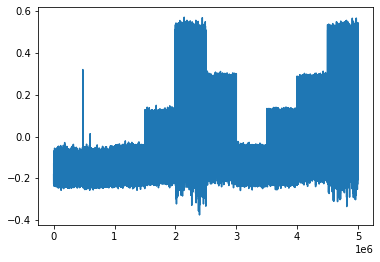

In [20]:
# apply every feature to data
# kal_df = divide_and_add_features(kal_data['signal'])
# df = divide_and_add_features(data['signal'])

df = divide_and_add_features(kal_data['signal'], 'train', 500000)
df = reduce_mem_usage(df)   ##Reduce memory usage
df = df.reset_index(drop=True)
# df = remove_batch7_spike(df)
# Y_train_proba = np.load("./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/Y_train_proba.npy")

# for i in range(11):
#     df[f"proba_{i}"] = Y_train_proba[:, i]

# raw_train = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/oof_wavenet_iiyatu.csv')
# df['oof_wavenet'] = raw_train['open_channels'].values

# feats= []
# for feat in kal_df.columns :
#   feats.append('kal_' + feat)
# kal_df.columns = feats

# df = pd.concat([df, kal_df], axis=1) 

df

In [21]:
df = reduce_mem_usage(df)   ##Reduce memory usage

Mem. usage decreased from 886.92 Mb to 886.92 Mb (0.0% reduction)


In [0]:
# df1 = df[B_SIZE:B_SIZE*2]
# df = df[0:B_SIZE]

In [0]:
X = df
y = data["open_channels"]

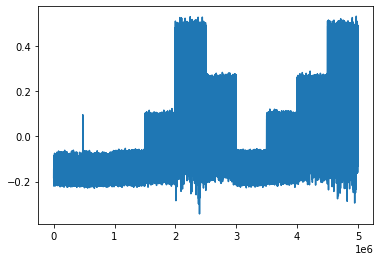

In [24]:
plt.plot(X['lowpass_ff_0.5012'])

In [0]:
# mfcc_ = pd.DataFrame()
# mfcc_['lowpass_ff_0.5012'] =  X['lowpass_ff_0.5012'].values
# mfcc_.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_lowpass_ff_0.5012.csv', index=False)

In [0]:
# y1 = y[B_SIZE:B_SIZE*2]
# y = y[0:B_SIZE]

**Calculatting Class weight**

class_weight= [  4.03176385   5.07168831   9.02650905   7.47821223  12.39433827
  17.9935727   26.57990984  18.86685659  20.39293099  36.73229503
 139.92667842]


Text(0.5, 1.0, 'class_weight')

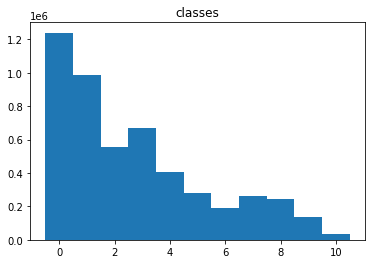

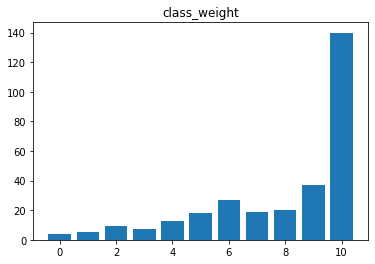

In [24]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = get_class_weight(y)
print('class_weight=', class_weight)
plt.figure()
plt.title('classes')
plt.hist(y, bins=np.arange(12)-0.5)
plt.figure()
plt.title('class_weight')
plt.bar(np.arange(11), class_weight)
plt.title('class_weight')

Reading test data

Reading data...


  0%|          | 0/200 [00:00<?, ?it/s]

Feature engineering...


100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


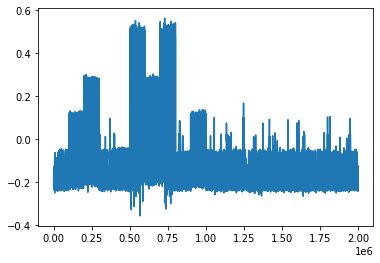

In [25]:
print('Reading data...')
# kal_td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean_kalman.csv')
# td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/test_clean.csv')
td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/test_clean_kalman_rem_50hz.csv')
# plt.plot(td['signal'])

# td = td[B_SIZE:2*B_SIZE]
# td.reset_index(inplace=True)
# td.drop('index', axis=1, inplace=True)
    
print('Feature engineering...')
# kal_tdf = divide_and_add_features(td['signal'])
tdf = divide_and_add_features(td['signal'], 'test', 10000)
tdf = tdf.reset_index(drop=True)
# tdf = remove_batch7_spike(tdf)

# Y_test_proba = np.load("./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/Y_test_proba.npy")

# for i in range(11):
#     tdf[f"proba_{i}"] = Y_test_proba[:, i]

# raw_test = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/submission_wavenet_iiyatu.csv')
# tdf['oof_wavenet'] = raw_test['open_channels'].values
# feats= []
# for feat in kal_tdf.columns :
#   feats.append('kal_' + feat)
# kal_tdf.columns = feats

# tdf = pd.concat([tdf, kal_tdf], axis=1) 

In [26]:
tdf = reduce_mem_usage(tdf)
tdf

Mem. usage decreased from 1419.07 Mb to 354.77 Mb (75.0% reduction)


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_min_10,roll_max_10,roll_range_10,roll_median_10,roll_mean_50,roll_std_50,roll_min_50,roll_max_50,roll_range_50,roll_median_50,roll_mean_100,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,ewm_mean_5,ewm_std_5,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000
0,-0.178711,-0.013046,0.006271,0.006954,-0.006390,-0.178711,-0.176880,-0.178711,-0.177368,-0.178711,-0.177979,-0.178711,-0.178589,-0.178711,-0.178833,-0.178711,-0.178833,-0.178711,-0.178833,-0.178711,-0.178711,-0.178711,-0.178711,-0.178711,-0.178711,0.000000,-0.001921,-0.000000,-0.001374,0.000000,-0.000642,0.000000,-0.000086,0.000000,0.000097,0.000000,0.000053,0.000000,0.000011,0.000000,...,-0.192261,-0.165039,0.027313,-0.178711,-0.182617,0.016068,-0.210205,-0.154175,0.056030,-0.184570,-0.179443,0.015091,-0.210205,-0.151611,0.058533,-0.179932,-0.179321,0.016815,-0.225952,-0.134277,0.091736,-0.179321,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,-0.178711,0.000000,-0.178711,0.000000,-0.178711,0.000000,-0.178711,0.000000,-0.178711,0.000000,-0.178711,0.000000
1,-0.191772,-0.006775,0.013229,0.000564,-0.008987,-0.178955,-0.176880,-0.179077,-0.177490,-0.179199,-0.178223,-0.179443,-0.178955,-0.179810,-0.179443,-0.180298,-0.179688,-0.181030,-0.180298,-0.182129,-0.181763,-0.183472,-0.184570,-0.185303,-0.188721,-0.012840,-0.014870,-0.012718,-0.014259,-0.012527,-0.013412,-0.012222,-0.012680,-0.011749,-0.012238,-0.011055,-0.011787,-0.010048,-0.010567,-0.008636,...,-0.192261,-0.165039,0.027313,-0.177490,-0.181519,0.016708,-0.210205,-0.154175,0.056061,-0.181641,-0.179443,0.014946,-0.210205,-0.151611,0.058533,-0.180542,-0.179443,0.016815,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,-0.186523,0.009224,-0.185913,0.009224,-0.185425,0.009224,-0.185303,0.009224,-0.185303,0.009224,-0.185303,0.009224
2,-0.192261,0.013405,0.007401,-0.011017,-0.003653,-0.179321,-0.177002,-0.179688,-0.177612,-0.180176,-0.178345,-0.180908,-0.179199,-0.181885,-0.179688,-0.183228,-0.179932,-0.184937,-0.180176,-0.187134,-0.181152,-0.189575,-0.182983,-0.192017,-0.185303,-0.012939,-0.015289,-0.012573,-0.014633,-0.012009,-0.013702,-0.011139,-0.012901,-0.009865,-0.012482,-0.008095,-0.012253,-0.005810,-0.011520,-0.003132,...,-0.192261,-0.165039,0.027313,-0.178711,-0.180908,0.016769,-0.210205,-0.154175,0.056061,-0.178711,-0.179321,0.014816,-0.210205,-0.151611,0.058533,-0.179932,-0.179443,0.016830,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,-0.189331,0.006851,-0.188477,0.007290,-0.187744,0.007607,-0.187744,0.007645,-0.187622,0.007671,-0.187622,0.007675
3,-0.165039,0.008026,-0.008804,-0.006741,0.007355,-0.179321,-0.177124,-0.179688,-0.177734,-0.180054,-0.178589,-0.180664,-0.179321,-0.181274,-0.179810,-0.182129,-0.179688,-0.182739,-0.179077,-0.182861,-0.178223,-0.181763,-0.176880,-0.178589,-0.174561,0.014351,0.012100,0.014687,0.012794,0.015175,0.013771,0.015854,0.014587,0.016693,0.014824,0.017517,0.014397,0.017899,0.013565,0.017075,...,-0.192261,-0.165039,0.027313,-0.1816

In [0]:
# mfcc_ = pd.Da/taFrame()
# mfcc_['lowpass_ff_0.5012'] =  tdf['lowpass_ff_0.5012'].values
# mfcc_.to_csv('.drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_lowpass_ff_0.5012.csv', index=False)

**MLP MODEL**

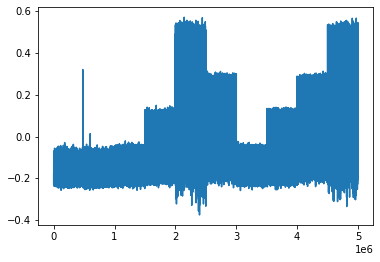

In [38]:
plt.plot(X['signal'])

In [39]:
tdf

,signal,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,roll_mean_5,roll_std_5,roll_min_5,roll_max_5,roll_range_5,roll_median_5,roll_mean_10,roll_std_10,roll_min_10,roll_max_10,roll_range_10,roll_median_10,roll_mean_50,roll_std_50,roll_min_50,roll_max_50,roll_range_50,roll_median_50,roll_mean_100,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,two_sig,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10
0,-0.178711,-0.178711,-0.176880,-0.178711,-0.177368,-0.178711,-0.177979,-0.178711,-0.178589,-0.178711,-0.178833,-0.178711,-0.178833,-0.178711,-0.178833,-0.178711,-0.178711,-0.178711,-0.178711,-0.178711,-0.178711,-0.187622,0.007679,-0.192261,-0.178711,0.013550,-0.191772,-0.180786,0.011490,-0.192261,-0.165039,0.027313,-0.178711,-0.182617,0.016068,-0.210205,-0.154175,0.056030,-0.184570,-0.179443,0.015091,-0.210205,-0.151611,0.058533,-0.179932,-0.179321,0.016815,-0.225952,-0.134277,0.091736,-0.179321,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,0.031952,0.971191,0.025848,0.002903,0.000281,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.191772,-0.178955,-0.176880,-0.179077,-0.177490,-0.179199,-0.178223,-0.179443,-0.178955,-0.179810,-0.179443,-0.180298,-0.179688,-0.181030,-0.180298,-0.182129,-0.181763,-0.183472,-0.184570,-0.185303,-0.188721,-0.182007,0.012939,-0.192261,-0.165039,0.027313,-0.185303,-0.179565,0.010719,-0.192261,-0.165039,0.027313,-0.177490,-0.181519,0.016708,-0.210205,-0.154175,0.056061,-0.181641,-0.179443,0.014946,-0.210205,-0.151611,0.058533,-0.180542,-0.179443,0.016815,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,0.036774,0.992188,0.007454,0.000335,0.000068,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.192261,-0.179321,-0.177002,-0.179688,-0.177612,-0.180176,-0.178345,-0.180908,-0.179199,-0.181885,-0.179688,-0.183228,-0.179932,-0.184937,-0.180176,-0.187134,-0.181152,-0.189575,-0.182983,-0.192017,-0.185303,-0.180786,0.011490,-0.192261,-0.165039,0.027313,-0.178711,-0.180298,0.009964,-0.192261,-0.165039,0.027313,-0.178711,-0.180908,0.016769,-0.210205,-0.154175,0.056061,-0.178711,-0.179321,0.014816,-0.210205,-0.151611,0.058533,-0.179932,-0.179443,0.016830,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,0.036987,0.995605,0.003834,0.000271,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.165039,-0.179321,-0.177124,-0.179688,-0.177734,-0.180054,-0.178589,-0.180664,-0.179321,-0.181274,-0.179810,-0.182129,-0.179688,-0.182739,-0.179077,-0.182861,-0.178223,-0.181763,-0.176880,-0.178589,-0.174561,-0.179688,0.011978,-0.192261,-0.165039,0.027313,-0.176270,-0.181152,0.009560,-0.192261,-0.165039,0.027313,-0.181641,-0.180664,0.016495,-0.210205,-0.154175,0.056061,-0.178101,-0.178589,0.015732,-0.210205,-0.138184,0.071960,-0.179443,-0.179443,0.016800,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016296,-0.225952,-0.134277,0.091736,-0.179443,0.027222,0.994141,0.004578,0.001021,0.000036,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.176270,-0.179077,-0.177124,-0.179199,-0.177856,-0.179321,-0.178711,-0.179565,-0.179565,-0.179565,-0.180054,-0.179321,-0.179810,-0.178467,-0.178833,-0.176636,-0.177368,-0.173706,-0.175171,-0.170654,-0.172729,-0.178345,0.010490,-0.192261,-0.165039,0.027313,-0.176270,-0.182373,0.009583,-0.192261,-0.165039,0.027313,-0.184570,-0.180664,0.016205,-0.210205,-0.154175,0.056061,-0.178711,-0.178223,0.015869,-0.210205,-0.138184,0.071960,-0.179443,-0.179565,0.016769,-0.225952,-0.134277,0.091736,-0.179443,-0.179932,0.016

In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

In [0]:
# X = X[0:B_SIZE]
# y = y[0:B_SIZE]
# tdf = tdf[0:B_SIZE]

In [28]:

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

# params = {'boosting_type': 'gbdt',
#           'metric': 'rmse',
#           'objective': 'regression',
#           'n_jobs': -1,
#           'seed': 236}
#           # 'num_leaves': 280,
#           # 'learning_rate': 0.026623466966581126,
#           # 'max_depth': 73,
#           # 'lambda_l1': 2.959759088169741,
#           # 'lambda_l2': 1.331172832164913,
#           # 'bagging_fraction': 0.9655406551472153,
#           # 'bagging_freq': 9,
#           # 'colsample_bytree': 0.6867118652742716}

params = {
    'objective': 'multiclass',
    'num_class': 11,
    'metric': 'multi_logloss'}
    # 'learning_rate': 0.00987173774816051,
    # 'lambda_l1': 0.00031963798315506463,
    # 'lambda_l2': 0.18977456778807847,
    # 'num_leaves': 171, 
    # 'feature_fraction': 0.58733782457345, 
    # 'bagging_fraction': 0.7057826081907392, 
    # 'bagging_freq': 4}

oof_pred = np.zeros((len(X), 11))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 100, 
                      valid_sets = [train_set, val_set], verbose_eval = 100)
    
    # oof_pred[valid_index] = model.predict(X_valid)
    gbc_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_pred[valid_index] = gbc_pred
    # y_pred += model.predict(tdf) / folds.n_splits
    print(f1_score(y_valid, np.argmax(gbc_pred, axis=1), average='macro'))

    y_pred.append(model.predict(tdf, num_iteration=model.best_iteration))
    train_pred.append(model.predict(X, num_iteration=model.best_iteration))
    # break
    
rmse_score = np.sqrt(metrics.mean_squared_error(y, np.argmax(oof_pred, axis=1)))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
# oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
# round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, np.argmax(oof_pred, axis=1), average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')



Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0763245	valid_1's multi_logloss: 0.0825234
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0749354	valid_1's multi_logloss: 0.0795205
0.9403812412120451
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0757498	valid_1's multi_logloss: 0.0807873
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0748781	valid_1's multi_logloss: 0.078815
0.9403017274151712
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0760022	valid_1's multi_logloss: 0.0818759
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.0746075	valid_1's multi_logloss: 0.0793095
0.9392760617517824
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0742268	valid_1's multi_logloss: 0.0801554
Early stopping, best iteration is:
[95]	training's 

In [0]:
oof = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean_kalman_batch7_gause.csv')

oof = oof.drop('signal', axis=1)
oof['open_channels'] = oof_pred
oof.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sub.csv', index = False, float_format='%.4f')

ValueError: ignored

In [0]:
# round_y_pred = 
for i in range(len(y_pred)):
  if(i==0):
    round_y_pred = y_pred[i]
  else:
    round_y_pred += y_pred[i]
round_y_pred = np.argmax(round_y_pred.shape, axis=1) 

submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')

submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sub.csv', index = False, float_format='%.4f')
submission.head(20)

(500000, 11)

# K-Fold with MLP.

In [0]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    model = RFR(100)
    result =  model.fit(X_train, y_train)
    # model = CatBoostRegressor(learning_rate=0.15, depth=6, loss_function='RMSE', iterations=5000)
    # model=xgb.XGBRegressor(objective='reg:squarederror', eval_metric= 'rmse', n_jobs=-1, learning_rate=0.1)
    # model=lgb.LGBMRegressor(objective='regression', metric='rmse', n_estimators=5000, n_jobs=-1, learning_rate=0.1)
    # result =  model.fit(X_train, y_train,
    #                 eval_set=[(X_train, y_train),(X_valid, y_valid)],
    #                 early_stopping_rounds=100,
    #                 verbose = 100)

    # y_pred += model.predict(tdf) / folds.n_splits

    # oof_pred[valid_index] = model.predict(X_valid, num_iteration = result.best_iteration_)
    # y_pred.append(model.predict(tdf, num_iteration = result.best_iteration_))
    # train_pred.append(model.predict(X, num_iteration = result.best_iteration_))
    oof_pred[valid_index] = model.predict(X_valid)
    y_pred.append(model.predict(tdf.values))
    train_pred.append(model.predict(X.values))

    # break
rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, oof_pred, average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')

In [0]:
idxs = y != oof_pred
failed = np.zeros(len(oof_pred))
failed[idxs] = 1

# moving average
n = 200
b = np.ones(n)/n
failed_move = np.convolve(failed, b, mode='same')

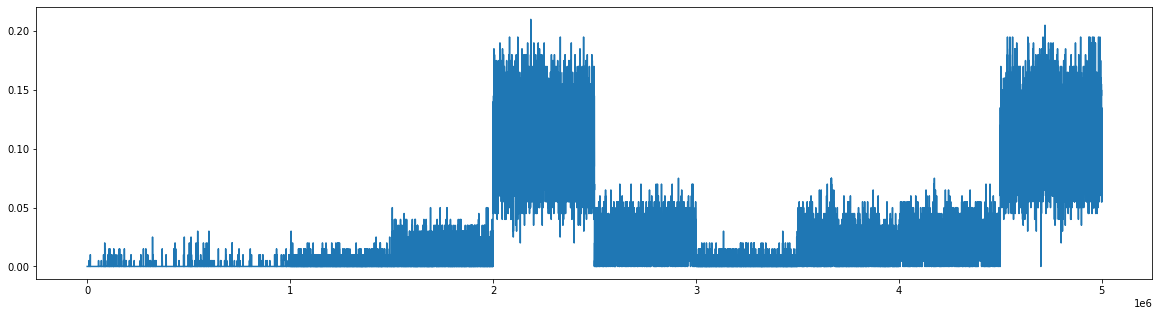

In [32]:
plt.figure(figsize=(20, 5))
plt.plot(failed_move)

In [0]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            X_valid_round = np.round(np.clip(self.model.predict(X_valid), 0, 10)).astype(int)
            self.base_score = self.metric(y_valid, X_valid_round, average = 'macro')
#             self.base_score = self.metric(y_valid, np.round(np.clip(self.model.predict(y_valid_pred), 0, 10)).astype(int))
        self.df_result = pd.DataFrame({'feat': X_valid.columns,
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                y_valid_pred_round = np.round(np.clip(y_valid_pred, 0, 10)).astype(int)
                score = self.metric(y_valid, y_valid_pred_round, average = 'macro')
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

        return self.df_result


In [0]:
pi = permutation_importance(model, f1_score) # model と metric を渡す
# X_valid_df = pd.DataFrame(X_valid, columns=X.columns)
# pi.compute(X_valid_df, y_valid )
# pi.show_permutation_importance(score_type='accuracy_score')  # loss or accuracy

In [87]:
df_ = pi.show_permutation_importance(score_type='accuracy_score')  # loss or accuracy
df_

AssertionError: ignored

In [73]:
pi.get_positive_feature()


['signal',
 'lowpass_lf_0.0100',
 'lowpass_ff_0.0100',
 'lowpass_lf_0.0154',
 'lowpass_ff_0.0154',
 'lowpass_lf_0.0239',
 'lowpass_ff_0.0239',
 'lowpass_lf_0.0369',
 'lowpass_ff_0.0369',
 'lowpass_ff_0.0570',
 'lowpass_lf_0.0880',
 'lowpass_ff_0.0880',
 'lowpass_lf_0.1359',
 'lowpass_ff_0.1359',
 'lowpass_lf_0.2100',
 'lowpass_ff_0.2100',
 'lowpass_lf_0.3244',
 'lowpass_lf_0.5012',
 'lowpass_ff_0.5012',
 'roll_mean_5',
 'roll_std_5',
 'roll_min_5',
 'roll_max_5',
 'roll_range_5',
 'roll_mean_10',
 'roll_std_10',
 'roll_min_10',
 'roll_max_10',
 'roll_range_10',
 'roll_median_10',
 'roll_mean_50',
 'roll_std_50',
 'roll_min_50',
 'roll_max_50',
 'roll_median_50',
 'roll_mean_100',
 'roll_std_100',
 'roll_max_100',
 'roll_range_100',
 'roll_median_100',
 'roll_mean_500',
 'roll_std_500',
 'roll_max_500',
 'roll_range_500',
 'roll_median_500',
 'roll_mean_1000',
 'roll_std_1000',
 'roll_min_1000',
 'roll_max_1000',
 'roll_range_1000',
 'roll_median_1000',
 'two_sig',
 'proba_0',
 'proba_1

In [0]:
X = X[pi.get_positive_feature()]
tdf = tdf[pi.get_positive_feature()]

In [0]:
def make_group(list_df):
  list_df_ = []
  for i in range(5):
    list_tmp = []
    if(i == 0):
      list_tmp.extend(list_df[0:B_SIZE])
      list_tmp.extend(list_df[B_SIZE:2*B_SIZE])
    if(i == 1):
      list_tmp.extend(list_df[2*B_SIZE:3*B_SIZE])
      list_tmp.extend(list_df[6*B_SIZE:7*B_SIZE])
    if(i == 2):
      list_tmp.extend(list_df[3*B_SIZE:4*B_SIZE])
      list_tmp.extend(list_df[7*B_SIZE:8*B_SIZE])
    if(i == 3):
      list_tmp.extend(list_df[4*B_SIZE:5*B_SIZE])
      list_tmp.extend(list_df[9*B_SIZE:10*B_SIZE])
    if(i == 4):
      list_tmp.extend(list_df[5*B_SIZE:6*B_SIZE])
      list_tmp.extend(list_df[8*B_SIZE:9*B_SIZE])
    # print(len(list_tmp))

    list_df_.append(list_tmp)

  return list_df_

In [30]:
df_score = pd.DataFrame()
list_score = []
for i in range(10):
  f1 = metrics.f1_score(y[i*B_SIZE:(i+1)*B_SIZE], oof_pred[i*B_SIZE:(i+1)*B_SIZE], average = 'macro')
  list_score.append(f1)
  print(f'Our oof macro f1 score is {f1}')


# df_score['score'] = list_score
# df_score.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/batchscore.csv')

Our oof macro f1 score is 0.6651596796161309
Our oof macro f1 score is 0.9970718171884609
Our oof macro f1 score is 0.6646963855669079
Our oof macro f1 score is 0.7896076947426324
Our oof macro f1 score is 0.7940249474390793
Our oof macro f1 score is 0.8340413150884689
Our oof macro f1 score is 0.6646513224120764
Our oof macro f1 score is 0.7835774240964444
Our oof macro f1 score is 0.8337893384475147
Our oof macro f1 score is 0.8651989101661558


In [31]:
y_group = make_group(y)
# y_group[0]
oof_pred_group = make_group(oof_pred)
for i in range(5):
  f1 = metrics.f1_score(y_group[i], oof_pred_group[i], average = 'macro')
  # list_score.append(f1)
  print(f'group {i} oof macro f1 score is {f1}')

group 0 oof macro f1 score is 0.6649165364296581
group 1 oof macro f1 score is 0.6646741167441982
group 2 oof macro f1 score is 0.7865613248171164
group 3 oof macro f1 score is 0.7901278532033603
group 4 oof macro f1 score is 0.833912390109771


In [1]:
for i in range(len(y_pred)):
  if i == 0:
    predpred = y_pred[i] / folds.n_splits
  else:
    predpred += y_pred[i] / folds.n_splits

round_y_pred = np.round(np.clip(predpred, 0, 10)).astype(int)

submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/sample_submission.csv')

submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/sub_rf_rem50.csv', index = False, float_format='%.4f')
submission.head(20)

NameError: ignored

In [0]:


submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean_kalman_batch7_gause_rem_50hz.csv')

submission['open_channels'] = oof_pred
submission = submission.drop('signal',axis=1)
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/oof_rf_rem50.csv', index = False, float_format='%.4f')
submission.head(20)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    ridge = Ridge()
    ridge.fit(X_train, y_train)


    # y_pred += model.predict(tdf) / folds.n_splits

    # oof_pred[valid_index] = model.predict(X_valid, num_iteration = result.best_iteration_)
    # y_pred.append(model.predict(tdf, num_iteration = result.best_iteration_))
    # train_pred.append(model.predict(X, num_iteration = result.best_iteration_))
    oof_pred[valid_index] = ridge.predict(X_valid)
    y_pred.append(ridge.predict(tdf.values))
    train_pred.append(ridge.predict(X.values))

    # break
rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, oof_pred, average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')

# MLP

Our oof rmse score is 0.15859318098150593
Our oof macro f1 score is 0.937621011766118


In [28]:
!pip install tensorflow==1.14

In [29]:
from keras.models import Model
import keras.layers as L
import tensorflow as tf
tf.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'1.14.0'

In [0]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)

    # X = L.Dense(150, activation='LeakyReLU')(X_input)
    # X = L.Dense(150, activation='LeakyReLU')(X)
    # X = L.Dense(125, activation='LeakyReLU')(X)
    # X = L.Dense(75, activation='LeakyReLU')(X)
    # X = L.Dense(50, activation='LeakyReLU')(X)
    # X = L.Dense(25, activation='LeakyReLU')(X)
    # X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


In [31]:
from sklearn.model_selection import StratifiedKFold
i=1;
n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)
scores = []
oof_pred = np.zeros((len(X), 11))

prediction = np.zeros(shape=(tdf.shape[0],11))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print(i,"*******th fold**************")
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    mlp = create_mpl(X_train[0].shape)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    mlp.fit(x=X_train, y=y_train, epochs=50, batch_size=1024, class_weight=class_weight)
    pred = mlp.predict(X_valid)
    oof_pred[valid_index] = pred
    pred = np.argmax(pred,axis=-1)
    score = f1_score_calc(y_valid, pred)
    print(score)
    #scores.append(score)
    y_pred = mlp.predict(tdf) 
    prediction += y_pred
    i = i+1

prediction /= n_fold
#print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))



1 *******th fold**************

Epoch 1/50
3750000/3750000 [==============================] - 46s 12us/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9514
Epoch 2/50
3750000/3750000 [==============================] - 46s 12us/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9617
Epoch 3/50
3750000/3750000 [==============================] - 46s 12us/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9625
Epoch 4/50
3750000/3750000 [==============================] - 47s 12us/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9630
Epoch 5/50
3750000/3750000 [==============================] - 47s 12us/step - loss: 0.0942 - sparse_categorical_accuracy: 0.9633
Epoch 6/50
3750000/3750000 [==============================] - 47s 12us/step - loss: 0.0934 - sparse_categorical_accuracy: 0.9635
Epoch 7/50
3750000/3750000 [==============================] - 49s 13us/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9637
Epoch 8/50
3750000/3750000 [==============================] - 46s

In [0]:
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/oof_mlp_proba_no_rfc_many_feature.npy', oof_pred)
# for i in range(len(y_pred)):
#   if(i==0):
#     round_y_pred = y_pred[i]
#   else:
#     round_y_pred += y_pred[i]
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/sub_mlp_proba_no_rfc_many_feature.npy', y_pred)

In [29]:
for i in range(len(y_pred)):
  if(i==0):
    round_y_pred = y_pred[i]
  else:
    round_y_pred += y_pred[i]
round_y_pred.shape

(2000000, 11)

In [32]:

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))
oof_proba = np.zeros((len(X), 11))
oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    model=lgb.LGBMRegressor(objective='regression', metric='rmse', n_estimators=5000, n_jobs=-1, learning_rate=0.1)
    model.fit(X_train, y_train)


    # y_pred += model.predict(tdf) / folds.n_splits
    oof_proba = model.predict_proba(X_valid, num_iteration = result.best_iteration_)
    oof_pred[valid_index] = model.predict(X_valid, num_iteration = result.best_iteration_)
    y_pred.append(model.predict(tdf, num_iteration = result.best_iteration_))
    train_pred.append(model.predict(X, num_iteration = result.best_iteration_))
    # oof_pred[valid_index] = ridge.predict(X_valid)
    # y_pred.append(ridge.predict(tdf.values))
    # train_pred.append(ridge.predict(X.values))

    break
# rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# # want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
# oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
# round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
# f1 = metrics.f1_score(y, oof_pred, average = 'macro')
# print(f'Our oof rmse score is {rmse_score}')
# print(f'Our oof macro f1 score is {f1}')

AttributeError: ignored